In [165]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 1. Active Learning Using Support Vector Machines

## (a) Download the banknote authentication Data Set 
from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points ran- domly as the test set. This is a binary classification problem.

In [166]:
banknote_df = df=pd.read_csv("data/data_banknote_authentication.txt",sep=",",header=None, 
               names=['variance','skewness','curtosis','entropy','class'])
banknote_df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [167]:
banknote_df.shape

(1372, 5)

In [168]:
train_df, test_df = train_test_split(banknote_df, test_size=472)
X_test = test_df.iloc[:,:4]
y_test = test_df['class']

## (b)
### i. passive learning

Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points.

In [169]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from math import log10
from tqdm import tqdm
from tqdm import trange

import warnings
warnings.filterwarnings("ignore")

In [170]:
def tune_linearSVC(X_train, y_train):
    '''
    tune the penalty parameter of LinearSVC
    return the best estinator chosen by CV
    '''
    #determine range for C
    C_s = np.logspace(-5, 5, 11)
    scores = []
    for c in C_s:
        svc = LinearSVC(penalty='l1', C=c, dual=False)
        svc.fit(X_train, y_train)
        scores.append(svc.score(X_train, y_train))
    scores = np.array(scores)
    index = np.argwhere(scores > 0.9).flatten()
    low = C_s[index[0]]
    high = C_s[index[-1]]
    
    #do fine grid cross validation
    C_vals = np.logspace(log10(low), log10(high), 20)
    param_grid = {'C': C_vals}
    
    svc = LinearSVC(penalty='l1', dual=False)
    n_splits = 10 if (len(X_train) > 10) else 5
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    clf = GridSearchCV(svc, param_grid, cv=kf, scoring='accuracy')
    clf.fit(X_train, y_train)
#     print('\tThe best C is', clf.best_params_['C'], ', CV-ed accurracy is', clf.best_score_)    
    return clf.best_estimator_  
        

In [ ]:
test_error_pl = []
for n in tqdm(range(50)):
    test_error = []
    
    #randomly select 10 points from the training set
    remaining, pool = train_test_split(train_df, test_size=10)
    #if the 10 samples belongs to the same class, re-sample
    while(len(pool['class'].unique()) == 1):
        print("Warning: Only one class!")
        print(pool)
        remaining, pool = train_test_split(train_df, test_size=10)
    clf = tune_linearSVC(pool.iloc[:,:4], pool['class'])
    test_error.append(1 - clf.score(X_test, y_test))

    for i in range(88):
        #randomly select 10 points from the remaining training set
        remaining, selected = train_test_split(remaining, test_size=10)
        pool = pool.append(selected)
#         print('pool size =', len(pool))
        clf = tune_linearSVC(pool.iloc[:,:4], pool['class'])
        test_error.append(1 - clf.score(X_test, y_test))

    #train on whole training set
    clf = tune_linearSVC(train_df.iloc[:,:4], train_df['class'])
    test_error.append(1 - clf.score(X_test, y_test))
    
    test_error_pl.append(test_error)

filepath1 = 'results/1_b_test_error.csv'
test_error_pl.to_csv(filepath1, index=False)

### ii. active learning

Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 10-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM2 and add them to the pool.

In [ ]:
test_error_active = []
for n in tqdm(range(50)):
    test_error = []
    
    #randomly select 10 points from the training set
    remaining, pool = train_test_split(train_df, test_size=10)
    #if the 10 samples belongs to the same class, re-sample
    while(len(pool['class'].unique()) == 1):
        remaining, pool = train_test_split(train_df, test_size=10)
    clf = tune_linearSVC(pool.iloc[:,:4], pool['class'])
    test_error.append(1 - clf.score(X_test, y_test))

    #calculate the distance from each point to the SVM hyperplace
    remaining['distance'] = clf.decision_function(remaining.iloc[:, :4])
    remaining.sort_values(by=['distance'])

    for i in range(88):
        #add the 10 closest data points to the hyperplane to the pool
        pool = pool.append(remaining.iloc[:10,:-1])
        remaining = remaining.iloc[10:]
#         print('pool size =', len(pool), 'remaining', len(remaining))
        clf = tune_linearSVC(pool.iloc[:,:4], pool['class'])
        test_error.append(1 - clf.score(X_test, y_test))

        remaining['distance'] = clf.decision_function(remaining.iloc[:, :4])
        remaining.sort_values(by=['distance'])

    #train on whole training set
    clf = tune_linearSVC(train_df.iloc[:,:4], train_df['class'])
    test_error.append(1 - clf.score(X_test, y_test))
    
    test_error_active.append(test_error)
    
filepath2 = 'results/1_b_ii_test_error.csv'
test_error_active.to_csv(filepath2, index=False)

## (c) Compare results

In [182]:
test_errors_pl = pd.read_csv(filepath1)
print('test errors for passive learners:')
test_errors_pl

test errors for passive learners:


,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.033898,0.016949,0.029661,0.021186,0.027542,0.027542,0.019068,0.019068,0.019068,0.019068,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
1,0.163136,0.091102,0.025424,0.012712,0.012712,0.012712,0.006356,0.006356,0.006356,0.010593,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
2,0.091102,0.088983,0.086864,0.031780,0.033898,0.025424,0.023305,0.014831,0.019068,0.016949,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
3,0.122881,0.091102,0.093220,0.080508,0.044492,0.025424,0.008475,0.008475,0.008475,0.014831,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
4,0.131356,0.095339,0.012712,0.019068,0.042373,0.038136,0.025424,0.025424,0.014831,0.012712,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
5,0.154661,0.052966,0.088983,0.010593,0.010593,0.014831,0.016949,0.012712,0.012712,0.008475,...,0.010593,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
6,0.082627,0.036017,0.014831,0.029661,0.025424,0.014831,0.014831,0.019068,0.019068,0.014831,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
7,0.165254,0.072034,0.006356,0.012712,0.006356,0.008475,0.014831,0.008475,0.008475,0.008475,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
8,0.038136,0.122881,0.080508,0.080508,0.016949,0.012712,0.012712,0.033898,0.038136,0.006356,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
9,0.156780,0.059322,0.006356,0.016949,0.014831,0.023305,0.021186,0.019068,0.019068,0.016949,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.010593,0.006356,0.006356,0.006356,0.006356


In [181]:
test_errors_al = pd.read_csv(filepath2)
print('test errors for active learners:')
test_errors_al

test errors for active learners:


,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.154661,0.095339,0.080508,0.095339,0.019068,0.019068,0.031780,0.019068,0.016949,0.016949,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.010593,0.006356,0.006356,0.006356,0.006356
1,0.203390,0.150424,0.078390,0.086864,0.084746,0.091102,0.074153,0.078390,0.023305,0.080508,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
2,0.127119,0.144068,0.129237,0.084746,0.033898,0.078390,0.029661,0.016949,0.012712,0.019068,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
3,0.127119,0.125000,0.129237,0.131356,0.050847,0.076271,0.038136,0.021186,0.080508,0.080508,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
4,0.023305,0.084746,0.078390,0.048729,0.044492,0.033898,0.052966,0.038136,0.033898,0.042373,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
5,0.078390,0.046610,0.033898,0.031780,0.012712,0.012712,0.021186,0.016949,0.014831,0.019068,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
6,0.016949,0.012712,0.050847,0.048729,0.016949,0.025424,0.033898,0.050847,0.055085,0.046610,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.010593
7,0.156780,0.055085,0.076271,0.084746,0.063559,0.067797,0.042373,0.052966,0.084746,0.084746,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
8,0.042373,0.029661,0.029661,0.029661,0.025424,0.029661,0.029661,0.027542,0.014831,0.014831,...,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356,0.006356
9,0.025424,0.014831,0.014831,0.014831,0.014831,0.050847,0.008475,0.010593,0.031780,0.012712,...,0.006356,0.010593,0.006356,0.006356,0.006356,0.010593,0.006356,0.006356,0.006356,0.006356


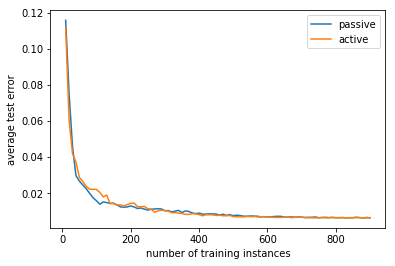

In [189]:
mean_error_pl = test_errors_pl.mean()
mean_error_al = test_errors_al.mean()

num_train = range(10, 901, 10)

plt.plot(num_train, mean_error_pl, label='passive')
plt.plot(num_train, mean_error_al, label='active')
plt.xlabel('number of training instances')
plt.ylabel('average test error')
plt.legend()

Text(0,0.5,'test error difference')

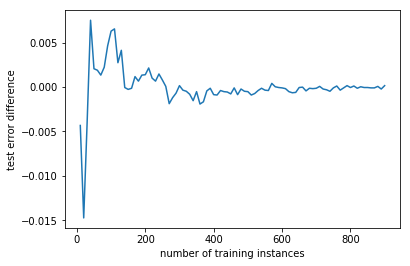

In [193]:
diff = mean_error_al.values - mean_error_pl.values
plt.plot(num_train, diff)
plt.xlabel('number of training instances')
plt.ylabel('test error difference')

Conclusion:

When the number of training instances is small, active learners perform better. As the number of training instances increase, passive learners outperform active learners. When the number of training instances is sufficiently large, the performace active learners and passive learners are basicly the same.